In [49]:
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd
from IPython import display
import seaborn as sns
from ContributorCentricFunctions import *
%matplotlib inline
from scipy import stats

In [3]:
years = [2005+i for i in range(12)]
years

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

In [4]:
study_tiles = json.loads(open('study_tiles_with_compare_tiles.json','r').read())
print("Found {0} tiles.".format(len(study_tiles)))

Found 7 tiles.


# Study Tiles: Load data for a specific study tile

In [5]:
for idx, tile in enumerate(study_tiles):
    print(idx, tile['name'])

0 Port Au Prince, Haiti
1 Tacloban, Philippines
2 Monrovia, Liberia
3 Trisuli Bazar, Nepal
4 Heidelberg, Germany
5 London, UK
6 Manhattan, NY


## 1. Get the `user_list` by setting the `study_tile_idx` to the appropriate study tile

In [10]:
study_tile_idx = 0

In [7]:
reset() #Safety for the db connections
study_tiles[study_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

In [8]:
print("Found: {0} users".format(len(study_tiles[study_tile_idx]['user_list'])))

Found: 440 users


## 2. Build the User Distributions
If this doesn't run, run the cell 2 above again)

In [9]:
study_tiles[study_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['user_list'])
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['df'].head(2))

 2194/ ~ 2112

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,102322322323,2005,143,0,0.0,0,5,1,143,sxpert,2005,0,0.0,0,1154,5
1,120032111012,2005,143,0,0.0,0,12,1,143,sxpert,2005,0,0.0,0,1154,5


## 3. Get tile focus for each user

In [11]:
process_dictionary_of_users(study_tiles[study_tile_idx]['users'])
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['tiles'].head(2))
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['annual'].head(2))

 440/440

,road_km,amenities,edits,num_days,buildings,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits
quadkey,,,,,,,,,
031331301203,0.000000,0,2,1,0,0.00000,0.0,0.0,0.003337
031333131030,0.042327,0,1,1,0,0.00261,0.0,0.0,0.001668


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,143,sxpert,2005,0,0.000,0,1154,5
1,143,sxpert,2006,0,61.198,5,18406,48


## 3.5 Get Study Tile Focus

In [12]:
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['users'], study_tiles[study_tile_idx]['quad'])
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['toi'].head(2))

 425/440

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
481,032211203001,2010,143,149,2.64401,0,174,2,143,sxpert,2010,257,42.1018,13,975,14


## 4. Who is mapping what: Build Current Tile DF

In [13]:
current_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx])
current_tile_df.head(2)

,road_km,amenities,edits,num_days,buildings,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits,uid,total_editing_days_ever,total_buildings_ever,total_road_km_ever,total_amenities_ever,total_edits_ever,percent_tile_road_km,percent_tile_buildings,percent_tile_amenities,percent_tile_edits
0,3.1632,1,250,13,151,0.152193,0.455437,0.212314,0.635922,1443840,276,33155,2078.4218,471,39313,0.108544,1.015331,0.013622,0.572253
1,0.0000,0,2,1,0,0.000000,0.000000,0.000000,0.000440,307202,998,7659,128673.0430,6275,454250,0.000000,0.000000,0.000000,0.004578


### Processed Study tiles now have the following attributes: 

- **name**: Name of Region
- **user_list**: List of UIDs of users who have edited on this tile
- **users**: Dictionary, keyed by UID
  - `uid`:
    - **df**: Full dataframe of all edits on all tiles by this user
    - **tiles**: DataFrame of unique tiles, summed over all years
    - **annual**: DataFrame of Editing Aggregates over all tiles, per year

# Begin Analysis of Tile

In [14]:
print("Current Study Tile: {0}".format(study_tiles[study_tile_idx]['name']))
print("\tUsers: {0}".format(len(study_tiles[study_tile_idx]['user_list'])))
print("Current_tile_df size: {0} (Should match the user count)".format(len(current_tile_df)))

Current Study Tile: Port Au Prince, Haiti
	Users: 440
Current_tile_df size: 440 (Should match the user count)


## Percentage of a User's edits (of all time) that occur on this tile: 

# 1.  Users active on this tile overtime

In [15]:
overtime_df = get_active_users_overtime_df(study_tiles[study_tile_idx]['users'])

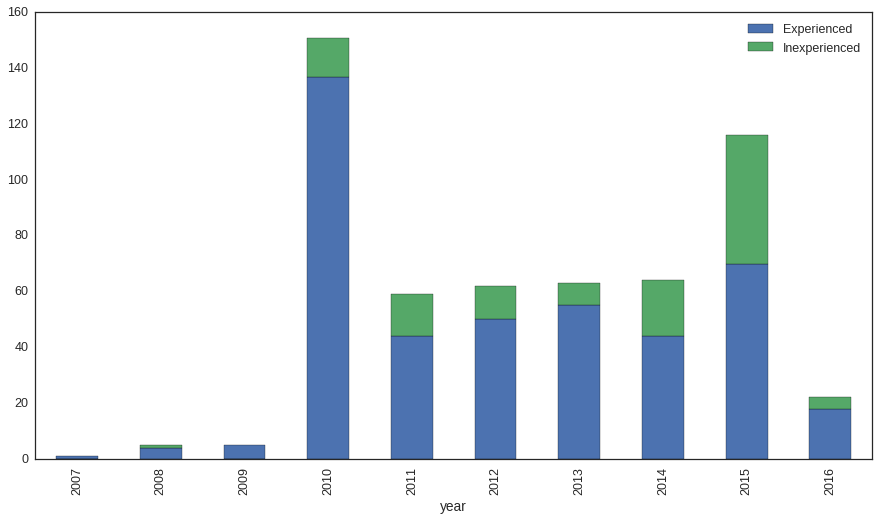

In [16]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,8), facecolor='w', edgecolor='k')

#How many days (to date) is considered experienced?
threshold = 7

gt_10 = overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
lt_10 = overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})

gt_10.columns = ['Experienced']
lt_10.columns = ['Inexperienced']

gt_10.join(lt_10).plot(ax=axs,kind='bar',stacked=True)

# 2: User Experience 

Who's Mapping Buildings and Roads?

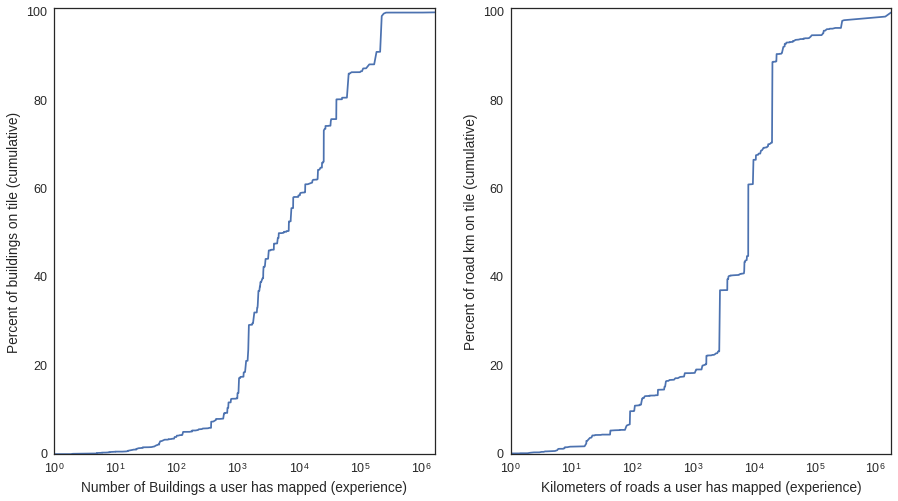

In [17]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

b_view = current_tile_df.sort_values(by='total_buildings_ever')
b_view['cumulative_percent'] = b_view.percent_tile_buildings.cumsum()

b_view.plot(ax=axs[0],x='total_buildings_ever',y='cumulative_percent', logx=True,legend=None)

axs[0].set_ylabel('Percent of buildings on tile (cumulative)')
axs[0].set_xlabel('Number of Buildings a user has mapped (experience)')


r_view = current_tile_df.sort_values(by='total_road_km_ever')
r_view['cumulative_percent'] = r_view.percent_tile_road_km.cumsum()

r_view.plot(ax=axs[1],x='total_road_km_ever',y='cumulative_percent', logx=True,legend=None)

axs[1].set_ylabel('Percent of road km on tile (cumulative)')
axs[1].set_xlabel('Kilometers of roads a user has mapped (experience)')

for ax in axs:
    ax.set_ylim(0,101)
    ax.set_xlim(1)

# 3. User Focus

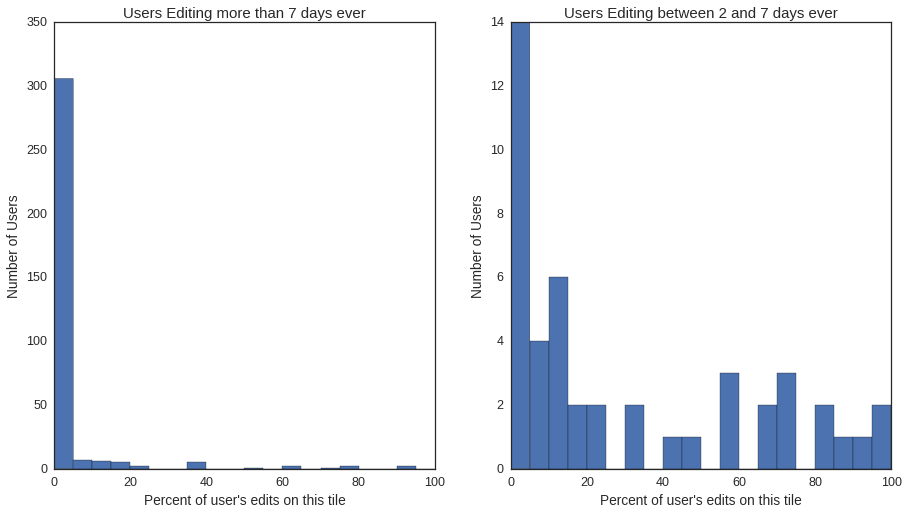

In [18]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

current_tile_df.query('total_editing_days_ever>7').query('total_editing_days_ever>1').plot(ax=axs[0], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[0].set_title('Users Editing more than 7 days ever')

current_tile_df.query('total_editing_days_ever<7').query('total_editing_days_ever>1').plot(ax=axs[1], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,5))
axs[1].set_title('Users Editing between 2 and 7 days ever')

for ax in axs:
    ax.set_xlabel("Percent of user's edits on this tile")
    ax.set_ylabel('Number of Users')

This is still not _quite_ right, there are better ways to show this type of _User Focus_

<br>
<hr>
<br>
<br>
# Run Tile-by-Tile Comparisons
For each study tile, we have _comparable_ tiles, these are the tiles of most interest, because the difference in patterns between these tiles and our study tiles is what makes the analysis.

#### 1. Get a _comparable_ tile

[Compareable tiles for Port Au Prince can be found here](http://www.townsendjennings.com/geojson-polygons?geojson=http://epic-analytics.cs.colorado.edu:9000/jennings/iscram/Port%20Au%20Prince%2c%20Haiti_sim_tiles.geojson#1/8/135)

In [19]:
if 'compare_tiles' in study_tiles[study_tile_idx]:
    print("Comparable Tiles for {0}: ".format(study_tiles[study_tile_idx]['name']))
    for idx, compare in enumerate(study_tiles[study_tile_idx]['compare_tiles']):
        print("\t{0}, '{1}'".format(idx, compare['quad']))

Comparable Tiles for Port Au Prince, Haiti: 
	0, '033110210131'


In [20]:
#Which tile to compare? (from within the comparable study tiles)
compare_tile_idx=0 #That's Lisbon, Portugal (the most comparable tile)

#### 2. Get Users
If it breaks, run it again :) 

In [25]:
reset()
reset()
reset()
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

#### 3. Build actual user distribution (may take a few minutes)
If it fails, run the above cell again (probably twice)

In [26]:
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'])

 1150/ ~ 1258

#### 4. Now process user focus for compare tiles

In [27]:
process_dictionary_of_users(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'])
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'], study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['quad'])

display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['toi'].head(2))
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['tiles'].head(2))
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['annual'].head(2))

 259/262

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
481,032211203001,2010,143,149,2.64401,0,174,2,143,sxpert,2010,257,42.1018,13,975,14


,road_km,amenities,edits,num_days,buildings,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits
quadkey,,,,,,,,,
002302201211,0.0,0,2,1,0,0.0,0.0,0.0,0.000399
002302201212,0.0,0,2,1,0,0.0,0.0,0.0,0.000399


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,1164,dmgroom,2006,2,1570.1,377,48203,200
1,1164,dmgroom,2007,33,13734.6,197,127948,269


#### 5. Build Compare Tile Full Stats

In [28]:
compare_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])
compare_tile_df.count().head(2)

road_km      262
amenities    262
dtype: int64

In [29]:
compare_overtime_df = get_active_users_overtime_df(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'])
compare_overtime_df.head(2)

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
0,033110210131,2014,2180097,0,0.227178,0,1,1,2180097,José Borbinha,2014,0,0.227178,0,1,1,1
1,033110210131,2011,74155,0,0.000000,0,6,1,74155,AndreRoeder,2011,0,0.000000,1,9,1,2


<br>
<br>
<hr>

# Now we can compare Port Au Prince to its similar tile

First, basic stats: 

In [30]:
print("Users on Study Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['user_list']), len(current_tile_df)))
print("Users on Compare Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list']), len(compare_tile_df)))

Users on Study Tile: 440, 440
Users on Compare Tile: 262, 262


# 1.  Users active on the tiles overtime

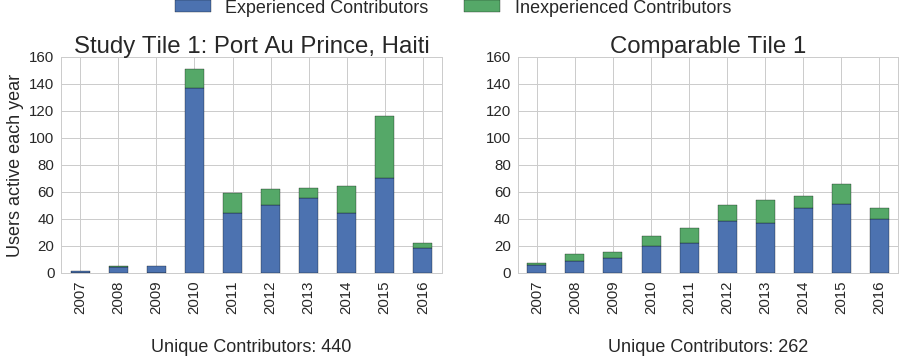

In [127]:
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6), facecolor='w', edgecolor='k')
plt.subplots_adjust(left=None, bottom=0.4, right=None, top=None, wspace=None, hspace=0.1)

#How many days (to date) is considered experienced?
threshold = 7
#Study Tile
gt_10 = overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
lt_10 = overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
gt_10.columns = ['Experienced Contributors']
lt_10.columns = ['Inexperienced Contributors']
gt_10.join(lt_10).plot(ax=axs[0],kind='bar',stacked=True)

#Compare DF
compare_gt_10 = compare_overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
compare_lt_10 = compare_overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
compare_gt_10.columns = ['Experienced Contributors']
compare_lt_10.columns = ['Inexperienced Contributors']
compare_gt_10.join(compare_lt_10).plot(ax=axs[1],kind='bar',stacked=True)

axs[0].set_ylabel("Users active each year",fontsize=18)
axs[0].set_title("Study Tile {0}: ".format(study_tile_idx+1)+study_tiles[study_tile_idx]['name'],fontsize=24)
axs[0].set_xlabel("\nUnique Contributors: {0}".format(len(current_tile_df)),fontsize=18)

axs[1].set_title("Comparable Tile {0}".format(study_tile_idx+1),fontsize=24)
axs[1].set_xlabel("\nUnique Contributors: {0}".format(len(compare_tile_df)),fontsize=18)


axs[1].set_ylim(axs[0].get_ylim())

                 
for ax in axs:
    ax.legend_.remove()

handles, labels = axs[1].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper center', ncol=2, fontsize=18, borderaxespad=-0.4);

### Analysis
Port Au Prince's similar tile, in this case, Singapore, shows a steady, growing group of contributors. In total, 100 more contributors have been active on that tile. Moreover, more inexperienced contributors overall. So while the data in Haiti may be _stale_, there are more _experienced contributors_ that were active.

### Calculate the percentages of new to experienced

In [119]:
print(" Ratio of Experienced to Inexperienced {0:.1f}:1".format(
      (len(overtime_df.query('year==2010').query('active_days_to_date>=7')) / 
           len(overtime_df.query('year==2010').query('active_days_to_date<7')))
      ))

 Ratio of Experienced to Inexperienced 9.8:1


# Compare Buildings & Roads Across Two _Similar_ Tiles

## This is a proxy for _User Experience_

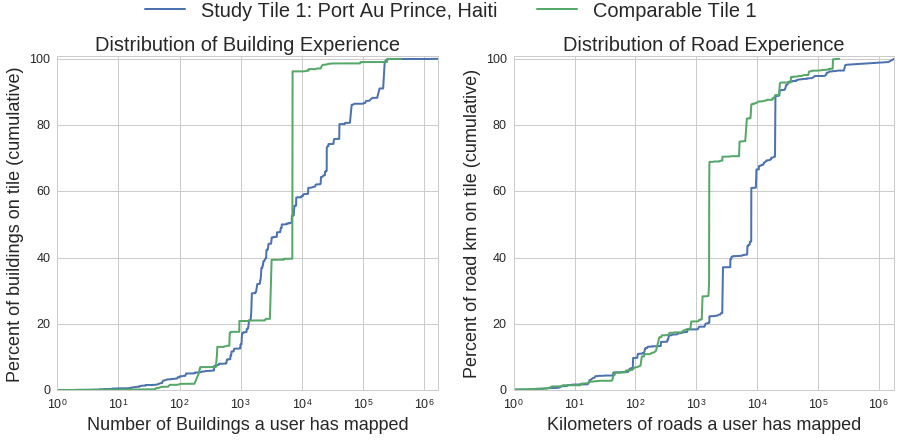

In [128]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,6), facecolor='w', edgecolor='k')

#Buildings
b_axis = axs[0]
b_view = current_tile_df.sort_values(by='total_buildings_ever')
b_view['cumulative_percent'] = b_view.percent_tile_buildings.cumsum()
b_view.plot(ax=b_axis,x='total_buildings_ever',y='cumulative_percent', logx=True,label=study_tiles[study_tile_idx]['name'], lw=2)

compare_b_view = compare_tile_df.sort_values(by='total_buildings_ever')
compare_b_view['cumulative_percent'] = compare_b_view.percent_tile_buildings.cumsum()
compare_b_view.plot(ax=b_axis,x='total_buildings_ever',y='cumulative_percent', logx=True,label="Similar Tile", lw=2)

b_axis.set_ylabel('Percent of buildings on tile (cumulative)', fontsize=18)
b_axis.set_xlabel('Number of Buildings a user has mapped', fontsize=18)

b_axis.set_title("Distribution of Building Experience", fontsize=20)

#Roads
r_axis = axs[1]
r_view = current_tile_df.sort_values(by='total_road_km_ever')
r_view['cumulative_percent'] = r_view.percent_tile_road_km.cumsum()
r_view.plot(ax=r_axis,x='total_road_km_ever',y='cumulative_percent', logx=True, lw=2,
            label="Study Tile {0}: ".format(study_tile_idx+1)+study_tiles[study_tile_idx]['name'])

compare_r_view = compare_tile_df.sort_values(by='total_road_km_ever')
compare_r_view['cumulative_percent'] = compare_r_view.percent_tile_road_km.cumsum()
compare_r_view.plot(ax=r_axis,x='total_road_km_ever',y='cumulative_percent', logx=True, lw=2,
                    label="Comparable Tile {0}".format(study_tile_idx+1))

r_axis.set_ylabel('Percent of road km on tile (cumulative)',fontsize=18)
r_axis.set_xlabel('Kilometers of roads a user has mapped',fontsize=18)

r_axis.set_title("Distribution of Road Experience", fontsize=20)

for ax in [r_axis, b_axis]:
    ax.set_ylim(0,101)
    ax.set_xlim(1)
    ax.legend_.remove()
    
handles, labels = axs[1].get_legend_handles_labels()
plt.figlegend(handles, labels, loc='upper center', ncol=2, fontsize=20, borderaxespad=-0.3);

### Analysis 
In the case of the similar tile, there was as large spike by a handful of users who have contributed thousands of buildings to the project that did most of the building mapping.

In [52]:
#KS Test
print("Buildings: ",stats.ks_2samp(b_view.cumulative_percent, compare_b_view.cumulative_percent))
print("Roads: ",stats.ks_2samp(r_view.cumulative_percent, compare_r_view.cumulative_percent))

Buildings:  Ks_2sampResult(statistic=0.24373698820263706, pvalue=4.5332112043641862e-09)
Roads:  Ks_2sampResult(statistic=0.17623178348369184, pvalue=6.0495695276390168e-05)


# Metric 3: User Geographic Focus?

How many users have only ever edited one day, and moreover, specifically on this tile...

In [33]:
compare_tile_df.head()

,road_km,amenities,edits,num_days,buildings,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits,uid,total_editing_days_ever,total_buildings_ever,total_road_km_ever,total_amenities_ever,total_edits_ever,percent_tile_road_km,percent_tile_buildings,percent_tile_amenities,percent_tile_edits
0,0.227178,0,1,1,0,100.000000,NaN,NaN,100.000000,2180097,1,0,0.227178,0,1,0.008343,0.0,0.0,0.002930
1,0.000000,0,6,1,0,0.000000,0.0,0.0,23.076923,74155,3,7,0.460077,4,26,0.000000,0.0,0.0,0.017583
2,0.000000,0,1,1,0,0.000000,0.0,0.0,0.003359,2566,440,93,2077.044736,325,29768,0.000000,0.0,0.0,0.002930
3,1.101980,0,4,1,0,0.002043,0.0,0.0,0.002496,13832,1771,777,53934.191000,266,160261,0.040471,0.0,0.0,0.011722
4,0.055324,0,2,1,0,0.000198,0.0,0.0,0.000858,196617,922,4170,27907.690000,1116,233097,0.002032,0.0,0.0,0.005861


Study Tile: 16% of contributors have more than 25% of their edits on this tile
Compare Tile: 26% of contributors have more than 25% of their edits on this tile


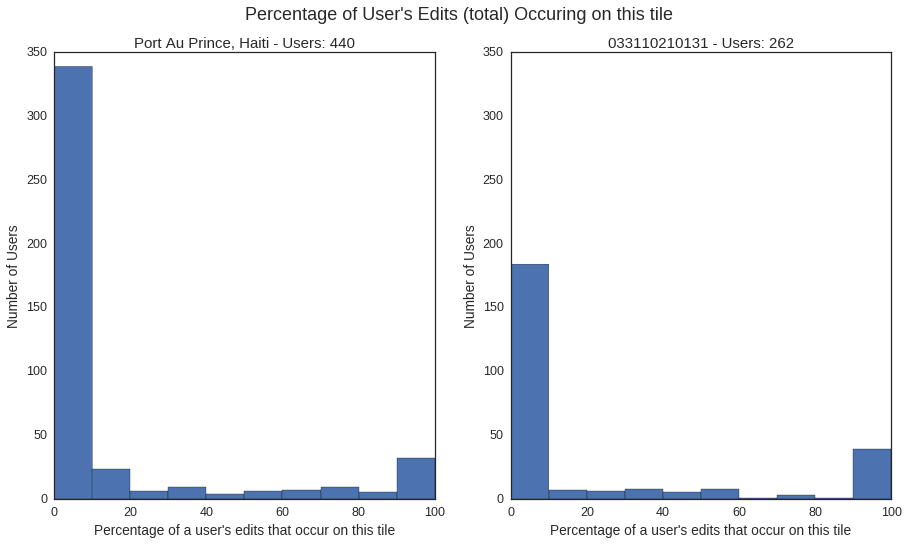

In [34]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

current_tile_df.plot(ax=axs[0], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,10))
axs[0].set_title(study_tiles[study_tile_idx]['name'] + " - Users: "+str(len(current_tile_df)))

compare_tile_df.plot(ax=axs[1], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,10))
axs[1].set_title(study_tiles[study_tile_idx]['compare_tiles'][idx]['quad'] + " - Users: "+str(len(compare_tile_df)))

axs[1].set_ylim(axs[0].get_ylim())

for ax in axs:
    ax.set_xlabel("Percentage of a user's edits that occur on this tile")
    ax.set_ylabel('Number of Users')
plt.suptitle("Percentage of User's Edits (total) Occuring on this tile",fontsize=18)

print("Study Tile: {0:.0f}% of contributors have more than 25% of their edits on this tile".format(len(current_tile_df.query('percent_user_edits>25')) / len(current_tile_df)*100))
print("Compare Tile: {0:.0f}% of contributors have more than 25% of their edits on this tile".format(len(compare_tile_df.query('percent_user_edits>25')) / len(compare_tile_df)*100))

## Analysis
Haiti continues to be the outlier in these metrics because it is so well mapped. Perhaps because the community was jumpstarted by the event. On both of these tiles, with hundreds of active users, the 

Study Tile: 16% of contributors have more than 25% of their edits on this tile
Compare Tile: 26% of contributors have more than 25% of their edits on this tile
----
Study Tile: 8% of experienced contributors have more than 10% of their edits on this tile
Compare Tile: 8% of experienced contributors have more than 10% of their edits on this tile


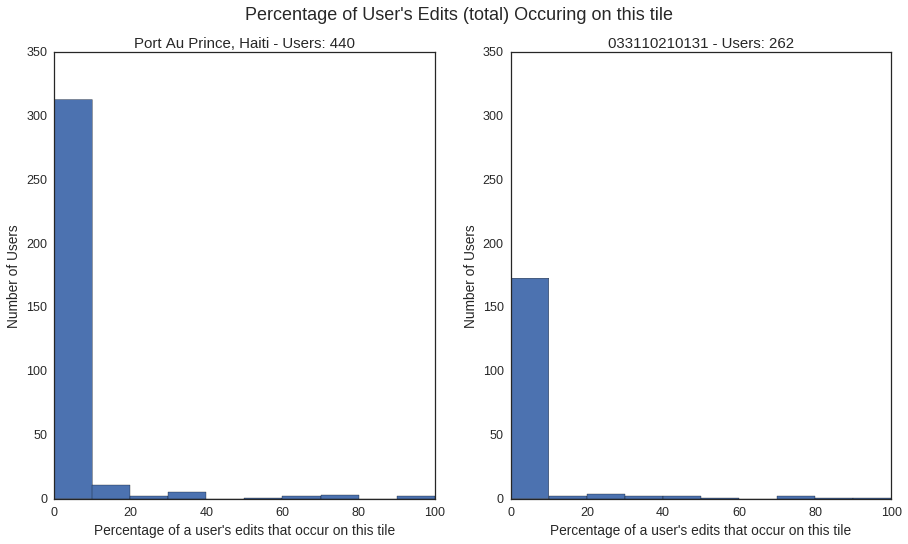

In [35]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,8), facecolor='w', edgecolor='k')

current_tile_df.query('total_editing_days_ever>7').plot(ax=axs[0], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,10))
axs[0].set_title(study_tiles[study_tile_idx]['name'] + " - Users: "+str(len(current_tile_df)))

compare_tile_df.query('total_editing_days_ever>7').plot(ax=axs[1], kind='hist',y=['percent_user_edits'], legend=None, bins=np.arange(0,101,10))
axs[1].set_title(study_tiles[study_tile_idx]['compare_tiles'][idx]['quad'] + " - Users: "+str(len(compare_tile_df)))

axs[1].set_ylim(axs[0].get_ylim())

for ax in axs:
    ax.set_xlabel("Percentage of a user's edits that occur on this tile")
    ax.set_ylabel('Number of Users')
plt.suptitle("Percentage of User's Edits (total) Occuring on this tile",fontsize=18)

print("Study Tile: {0:.0f}% of contributors have more than 25% of their edits on this tile".format(len(current_tile_df.query('percent_user_edits>25')) / len(current_tile_df)*100))
print("Compare Tile: {0:.0f}% of contributors have more than 25% of their edits on this tile".format(len(compare_tile_df.query('percent_user_edits>25')) / len(compare_tile_df)*100))
print("----")
print("Study Tile: {0:.0f}% of experienced contributors have more than 10% of their edits on this tile".format(len(current_tile_df.query('total_editing_days_ever>7').query('percent_user_edits>10')) / len(current_tile_df.query('total_editing_days_ever>7'))*100))
print("Compare Tile: {0:.0f}% of experienced contributors have more than 10% of their edits on this tile".format(len(compare_tile_df.query('total_editing_days_ever>7').query('percent_user_edits>10')) / len(compare_tile_df.query('total_editing_days_ever>7'))*100))

In [36]:
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['quad']

'033110210131'

## Another take on User Geographic Focus (Metric 3)
Given a user's experience, what's their percentage of edits on this tile?

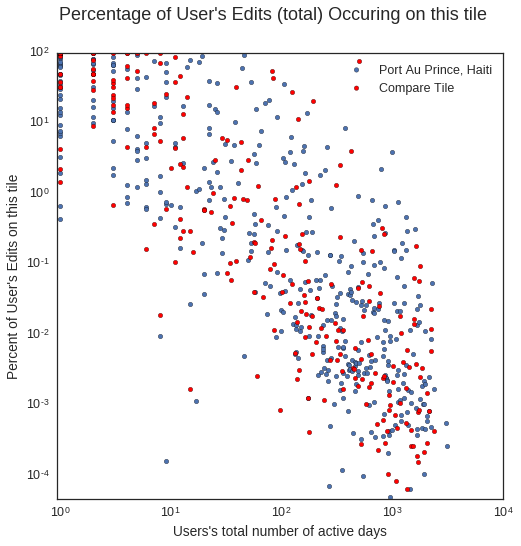

In [37]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,8), facecolor='w', edgecolor='k')

current_tile_df.sort_values(by='total_editing_days_ever').plot(kind='scatter',
    ax=axs,x='total_editing_days_ever',y='percent_user_edits', loglog=True, label=study_tiles[study_tile_idx]['name'])

compare_tile_df.sort_values(by='total_editing_days_ever').plot(kind='scatter', 
    ax=axs,x='total_editing_days_ever',y='percent_user_edits', loglog=True, color='red', label="Compare Tile")

axs.set_xlim(0,10000)
axs.set_ylim(0,100)
axs.set_xlabel("Users's total number of active days")
axs.set_ylabel("Percent of User's Edits on this tile")
plt.suptitle("Percentage of User's Edits (total) Occuring on this tile",fontsize=18)